In [1]:
import camb
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Introduction to Cosmology Physics - Final Project

## Functions

In [31]:
#---- Halo Mass-function ----#
def ombh2(Omega_m, h=0.675):
    return 0.16 * Omega_m * h**2

def omch2(Omega_m, h=0.675):
    return 0.84 * Omega_m * h**2

def P_L(H0=67.5, ombh2=ombh2(0.23), omch2=omch2(0.23), omk=0, TCMB=2.725, w=-1, z=[0], nonlinear=False):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, TCMB=TCMB, omk=omk)
    pars.set_dark_energy(w=w)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
    pars.set_matter_power(redshifts=z, kmax=1e1, nonlinear=nonlinear)
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-3, maxkh=1e1, npoints=200)
    return kh, pk[0]

def H(a, Omega_m=0.23, Omega_DE=0.77, H0=67.5):
    H = H0 * np.sqrt(Omega_m * a**(-3) + Omega_DE + (1 - Omega_m - Omega_DE) * a**(-2))
    return H

def D(z, Omega_m=0.23, Omega_DE=0.77, H0=67.5):
    a = 1 / (1 + z)
    prod = (5/2) * Omega_m * (H(a, Omega_m, Omega_DE, H0) / H0)
    def integrand(a_prime):
        integrand = 1 / (a_prime * H(a_prime, Omega_m, Omega_DE, H0) / H0)**3
        return integrand
    integral, _ = quad(integrand, 0, a)
    result = prod * integral
    return result

def W(k, R):
    W_func = 3 * (np.sin(k * R) / (k * R) - np.cos(k * R)) / (k * R)**2
    return W_func

def sigma(R, z=0):
    kh, pk = P_L(z=[z])
    pk_interpolated = interp1d(kh, pk, kind='linear')
    def integrand(k):
        Wk = W(k, R)
        return k**2 * pk_interpolated(k) * Wk**2 / (2 * np.pi ** 2)
    sigma_squared = quad(integrand, min(kh), max(kh))[0]
    sigma_value = D(z) * np.sqrt(sigma_squared)
    return sigma_value

def mass_to_radius(M, rho_m0=2.775e11):
    return (3 * M / (4 * np.pi * rho_m0)) ** (1/3)

def g_sigma(sigma, B=0.494, d=2.30, e=0.93, f=0.48, g=1.403):
    g_s = B * ( ( sigma / e ) ** (-d) + sigma ** (-f) ) * np.exp( - g / sigma ** 2 )
    return g_s

def dn_dM(M_values, sigma_M, d_ln_sigma_inv_d_ln_M, Omega_m=0.23, rho_m0=2.775e11):
    rho_m = rho_m0 * Omega_m
    f_s = g_sigma(sigma_M)
    dn_dM = f_s * rho_m * d_ln_sigma_inv_d_ln_M / M_values
    return dn_dM

#---- Halo Bias ----#
def b_sigma(sigma, delta=400, delta_c=1.686):
    v = delta_c / sigma
    y = np.log10(delta)
    A = 1 + 0.24 * y * np.exp( - (4 / y) ** 4 )
    a = 0.44 * y - 0.88
    B = 0.183
    b = 1.5
    C = 0.019 + 0.107 * y + 0.19 * np.exp( - (4 / y) ** 4 )
    c = 2.4
    bias = 1 - A *( v ** (a) / ( v ** (a) + delta_c ** (a) ) ) + B * v ** (b) + C * v ** (c)
    return bias

#---- Halo Profile ----#
def E2(z, Omega_m=0.23, Omega_DE=0.77, w=-1):
    E2 = Omega_m * (1 + z)**3 + Omega_DE * (1 + z)**(3 * (1 + w))
    return E2

def rho_crit(z, rho_m0=2.775e11, Omega_m=0.23, Omega_DE=0.77, w=-1):
    return rho_m0 * E2(z, Omega_m, Omega_DE, w)

def w_m(z, Omega_m=0.23):
    w_m = Omega_m * (1 + z) ** 3 / E2(z)
    return w_m

def Delta_c(z):
    x = w_m(z) - 1
    Delta_c = 18 * np.pi**2 + 82 * x - 39 * x**2
    return Delta_c

def r_vir(M_vir, z):
    rho_crit_value = rho_crit(z)
    Delta_c_value = Delta_c(z)
    r_vir = ( 3 * M_vir / (rho_crit_value * 4 * np.pi * Delta_c_value) ) ** (1/3)
    return r_vir

def c(M_vir, z, M_star):
    c = 9 / (1 + z) * ( M_vir / M_star ) ** (-0.13)
    return c

def rho_s(M_vir, z, M_star):
    rho_s_value = M_vir * c(M_vir, z, M_star) ** 3 / ( 4 * np.pi * r_vir(M_vir, z) * ( np.log( 1 + c(M_vir, z, M_star) ) - c(M_vir, z, M_star) / ( 1 + c(M_vir, z, M_star) ) ) )
    return rho_s_value

def radius_to_mass(R, rho_m0=2.775e11):
    M = 4 * np.pi * R**3 * rho_m0 / 3
    return M

def rho_r(r, M_vir, z, M_star):
    rho_s_value = rho_s(M_vir, z, M_star)
    c_value = c(M_vir, z, M_star)
    r_s = r_vir(M_vir, z) / c_value
    rho_r = rho_s_value / ( r / r_s * ( 1 + r / r_s ) ** 2 )
    return rho_r

def u_k(k, M_vir, M_star, z=0):
    r_vir_value = r_vir(M_vir, z)
    def mass_integrand(r):
        return 4 * np.pi * r**2 * rho_r(r, M_vir, z, M_star)
    M_vir_check, _ = quad(mass_integrand, 0, r_vir_value)
    def integrand(r):
        rho_r_value = rho_r(r, M_vir, z, M_star)
        return 4 * np.pi * r**2 * np.sin(k * r) / (k * r) * rho_r_value / M_vir_check
    u_k_value, _ = quad(integrand, 0, r_vir_value)
    return u_k_value

#---- Halo Model: Nonlinear Power Spectrum ----#
def P_1h(k, M_values, dn_dlnM, M_star, rho_m0=2.775e11):
    dn_dlnM_interp = interp1d(M_values, dn_dlnM, kind="linear", bounds_error=False, fill_value=0)
    
    def integrand(M):
        u_k_value = u_k(k, M, M_star=M_star)
        return (M / rho_m0**2) * dn_dlnM_interp(M) * np.abs(u_k_value)**2

    result, _ = quad(integrand, M_values[0], M_values[-1], epsabs=1e-5)
    return result

def P_2h(k, M_values, dn_dlnM, bias, M_star, rho_m0=2.775e11):
    kh, pk = P_L()
    pk_interpolated = interp1d(kh, pk, kind='linear', bounds_error=False, fill_value=0)
    dn_dlnM_interp = interp1d(M_values, dn_dlnM, kind="linear", bounds_error=False, fill_value=0)
    bias_interp = interp1d(M_values, bias, kind="linear", bounds_error=False, fill_value=0)

    def integrand(M):
        u_k_value = u_k(k, M, M_star=M_star)
        return (1 / rho_m0) * dn_dlnM_interp(M) * bias_interp(M) * u_k_value

    integral, _ = quad(integrand, M_values[0], M_values[-1], epsabs=1e-5)
    return (integral**2) * pk_interpolated(k)

## Halo Mass-function

In [3]:
# Is g(sigma) normalized?
def g_sigma_over_sigma(sigma, B=0.494, d=2.30, e=0.93, f=0.48, g=1.403):
    return g_sigma(sigma, B, d, e, f, g) / sigma

result, error = quad(g_sigma_over_sigma, 0, np.inf)
print(f'Integral result: {result}, Error estimate: {error}')

Integral result: 0.9941660718775818, Error estimate: 2.5652646673535173e-10


In [4]:
# Sigma values
M_values = np.logspace(10, 16, 100)  # Mass range in Msun/h
sigma_M_z0 = np.zeros(len(M_values))

for i, M in enumerate(M_values):
    R = mass_to_radius(M)
    sigma_M_z0[i] = sigma(R, z=0)
sigma_M_z1 = sigma_M_z0 * D(1) / D(0)

/tmp/ipykernel_22042/2698302334.py:42: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sigma_squared = quad(integrand, min(kh), max(kh))[0]


In [5]:
# dln(sigma -1)/dlnM values
d_ln_sigma_inv_d_ln_M_z0 = - M_values * np.gradient(sigma_M_z0, M_values) / sigma_M_z0
d_ln_sigma_inv_d_ln_M_z1 = - M_values * np.gradient(sigma_M_z1, M_values) / sigma_M_z1

In [6]:
# Halo mass values
dn_dM_z0 = dn_dM(M_values, sigma_M_z0, d_ln_sigma_inv_d_ln_M_z0)
dn_dM_z1 = dn_dM(M_values, sigma_M_z1, d_ln_sigma_inv_d_ln_M_z1)

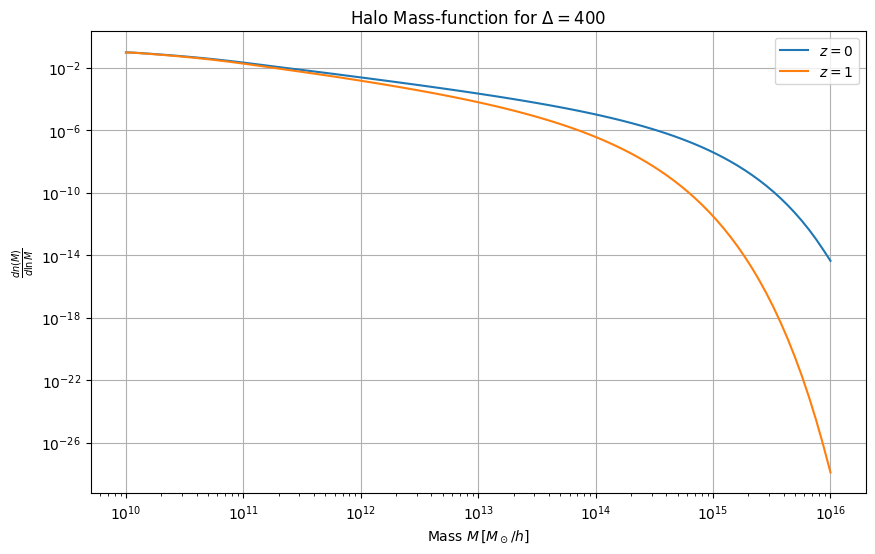

In [7]:
plt.figure(figsize=(10, 6))
plt.loglog(M_values, dn_dM_z0, label=r'$z=0$')
plt.loglog(M_values, dn_dM_z1, label=r'$z=1$')
plt.title(r'Halo Mass-function for $\Delta = 400$')
plt.xlabel(r'Mass $M \, [M_\odot/h]$')
plt.ylabel(r'$\frac{d n(M)}{d\ln M}$')
plt.legend()
plt.grid(True)
plt.savefig('halo_mass.png', dpi=240)
plt.show()

## Halo Bias

In [8]:
# Is b(z,M) normalized?
def g_b_sigma_over_v(sigma):
    return g_sigma(sigma) * b_sigma(sigma) / sigma

result, error = quad(g_b_sigma_over_v, 0, np.inf)
print(f'Integral result: {result}, Error estimate: {error}')

Integral result: 0.9921584754785774, Error estimate: 2.0063567474082333e-09


In [9]:
# Halo bias values
bias_z0 = b_sigma(sigma_M_z0)
bias_z1 = b_sigma(sigma_M_z1)

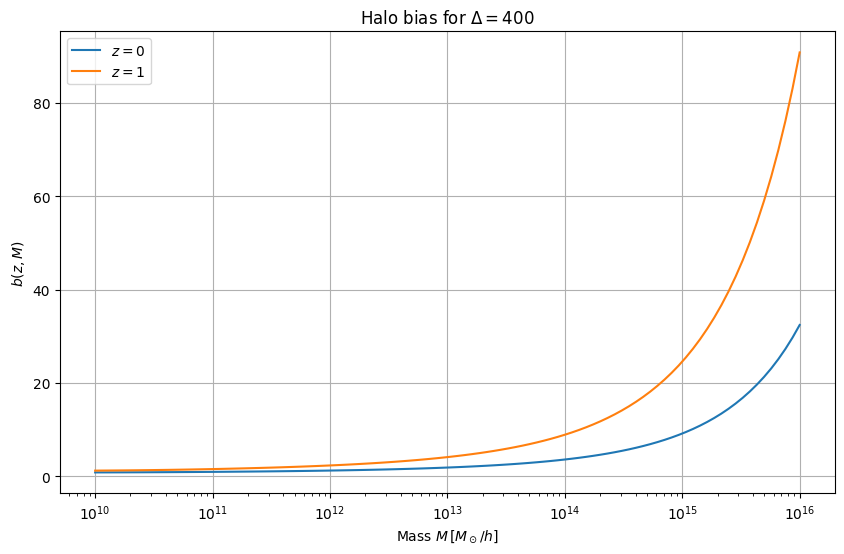

In [10]:
plt.figure(figsize=(10, 6))
plt.semilogx(M_values, bias_z0, label=r'$z=0$')
plt.semilogx(M_values, bias_z1, label=r'$z=1$')
plt.title(r'Halo bias for $\Delta = 400$')
plt.xlabel(r'Mass $M \, [M_\odot/h]$')
plt.ylabel(r'$b(z, M)$')
plt.legend()
plt.grid(True)
plt.savefig('halo_bias.png', dpi=240)
plt.show()

## Halo Profile

In [11]:
# Find M_star
def equation_to_solve(R, z, delta_c=1.686):
    return delta_c / sigma(R, z) - 1

R_0 = 1
R_star_z0 = fsolve(equation_to_solve, R_0, args=(0))[0]

M_star_z0 = radius_to_mass(R_star_z0)
M_star_z1 = M_star_z0 * D(1) / D(0)

print(f'M_star(z=0) = {M_star_z0}, M_star(z=1) = {M_star_z1}')

/tmp/ipykernel_22042/2698302334.py:42: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sigma_squared = quad(integrand, min(kh), max(kh))[0]


M_star(z=0) = 206323038511.21323, M_star(z=1) = 132002119869.97105


In [38]:
r_range = np.linspace(1e-2, 1e1, 100)
rho_r_z0_M14 = rho_r(r_range, 1e14, 0, M_star_z0)
rho_r_z0_M15 = rho_r(r_range, 1e15, 0, M_star_z0)
rho_r_z1_M14 = rho_r(r_range, 1e14, 1, M_star_z1)
rho_r_z1_M15 = rho_r(r_range, 1e15, 1, M_star_z1)

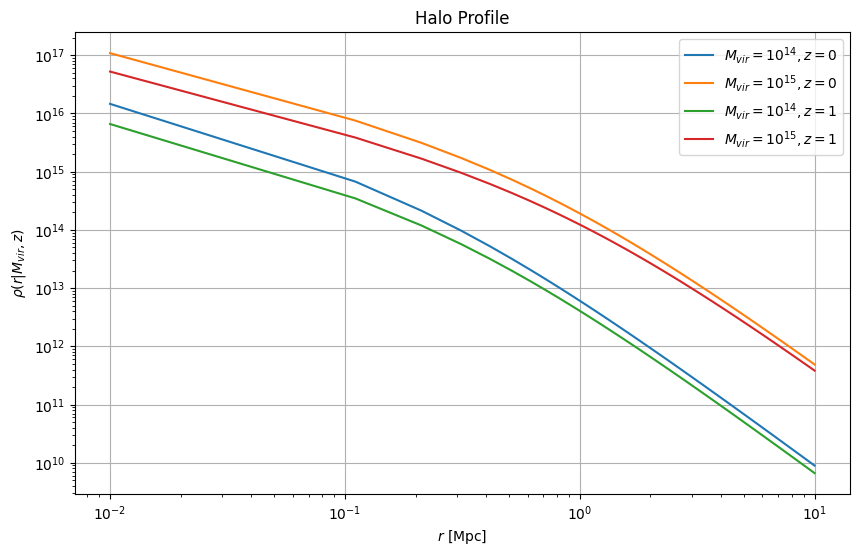

In [46]:
plt.figure(figsize=(10, 6))
plt.loglog(r_range, rho_r_z0_M14, label=r'$M_{vir}=10^{14}, z=0$')
plt.loglog(r_range, rho_r_z0_M15, label=r'$M_{vir}=10^{15}, z=0$')
plt.loglog(r_range, rho_r_z1_M14, label=r'$M_{vir}=10^{14}, z=1$')
plt.loglog(r_range, rho_r_z1_M15, label=r'$M_{vir}=10^{15}, z=1$')
plt.title(r'Halo Profile')
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$\rho(r|M_{vir}, z)$')
plt.legend()
plt.grid(True)
plt.savefig('halo_profile.png', dpi=240)
plt.show()

/tmp/ipykernel_22042/1825129325.py:122: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  u_k_value, _ = quad(integrand, 0, r_vir_value)
/tmp/ipykernel_22042/1825129325.py:122: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  u_k_value, _ = quad(integrand, 0, r_vir_value)


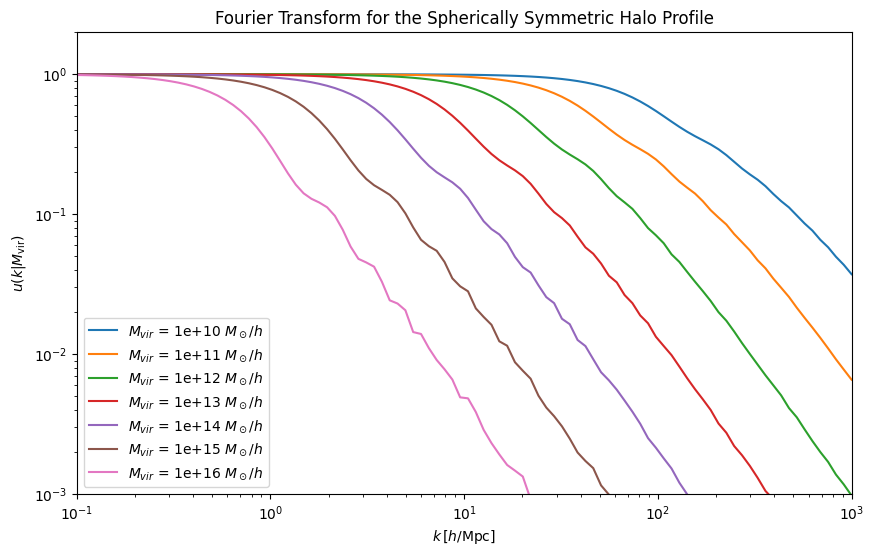

In [40]:
M_vir_values = [1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16]
k_values = np.logspace(-1, 3, 100)

plt.figure(figsize=(10, 6))
for M_vir in M_vir_values:
    u_k_values = [u_k(k, M_vir, M_star=M_star_z0, z=0) for k in k_values]
    plt.loglog(k_values, u_k_values, label=r'$M_{vir}$' + f' = {M_vir:.0e} ' + r'$M_\odot/h$')

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$u(k|M_{\mathrm{vir}})$')
plt.title('Fourier Transform for the Spherically Symmetric Halo Profile')
plt.ylim(1e-3, 0.2*1e1)
plt.xlim(1e-1, 1e3)
plt.legend()
plt.savefig('fourier_transform.png', dpi=240)
plt.show()

## Halo Model: Nonlinear Power Spectrum

In [41]:
M_values = np.logspace(10, 16, 100)
k_values = np.logspace(-3, 1, 100)
P_1h_values = np.array([P_1h(k, M_values, dn_dM_z0, M_star_z0) for k in k_values])
P_2h_values = np.array([P_2h(k, M_values, dn_dM_z0, bias_z0, M_star_z0) for k in k_values])

/tmp/ipykernel_22042/1825129325.py:133: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(integrand, M_values[0], M_values[-1], epsabs=1e-5)
/tmp/ipykernel_22042/1825129325.py:146: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

In [42]:
kh, pk = P_L()
kh_non, pk_non = P_L(nonlinear=True)

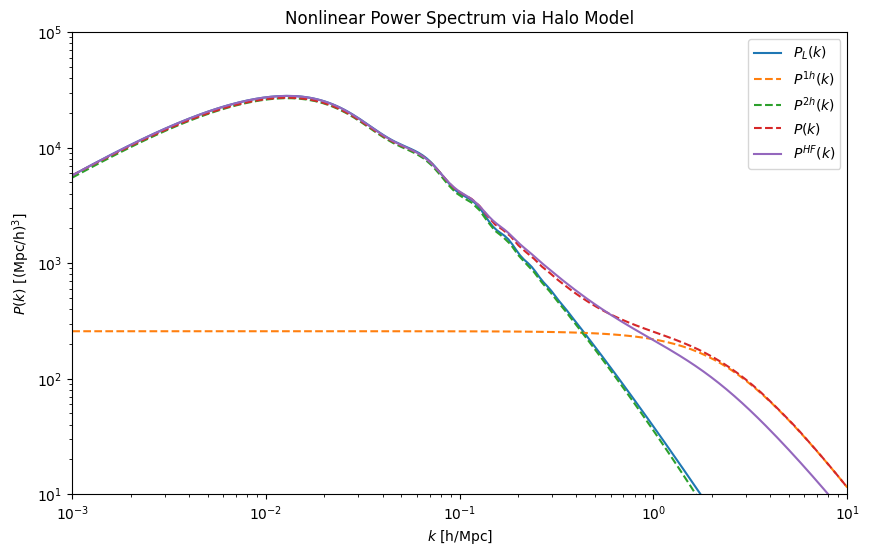

In [45]:
plt.figure(figsize=(10, 6))
plt.loglog(kh, pk, label=r'$P_L(k)$')
plt.loglog(k_values, P_1h_values, label=r'$P^{1h}(k)$', linestyle='--')
plt.loglog(k_values, P_2h_values, label=r'$P^{2h}(k)$', linestyle='--')
plt.loglog(k_values, P_1h_values + P_2h_values, label=r"$P(k)$", linestyle='--')
plt.loglog(kh_non, pk_non, label=r'$P^{HF}(k)$')
plt.xlabel(r"$k$ [h/Mpc]")
plt.ylabel(r"$P(k)$ [(Mpc/h)$^3$]")
plt.title("Nonlinear Power Spectrum via Halo Model")
plt.xlim(1e-3, 1e1)
plt.ylim(1e1, 1e5)
plt.legend()
plt.savefig('nonlinear_power_spectrum.png', dpi=240)
plt.show()